# Dataloader analyzer

In [30]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add the src directory to the path so we can import our modules
sys.path.append('/home/mg873uh/Projects_kb/baseline-codebase/src')

from data.datamodule import PretrainDataModule
from data.pretrain_split import get_pretrain_split_config
from augmentations.augmentation_composer import get_pretrain_augmentations, get_val_augmentations
from utils.utils import SimplePathConfig

print("Imports successful!")

Imports successful!


In [31]:
# Configuration values from run_pretraining.sh
pretrain_data_dir = "/home/mg873uh/Projects_kb/data/pretrain_preproc/FOMO60k"
model_name = "unet_b_lw_dec"
patch_size = 96
batch_size = 2
augmentation_preset = "all"
num_workers = 4  # Reduced for notebook use

# Create path config and splits
path_config = SimplePathConfig(train_data_dir=pretrain_data_dir)
splits_config = get_pretrain_split_config(
    method="simple_train_val_split",
    idx=0,
    split_ratio=0.01,  # 1% for validation
    path_config=path_config,
)

print(f"Train dataset size: {len(splits_config.train(0))}")
print(f"Val dataset size: {len(splits_config.val(0))}")
print(f"Patch size: {(patch_size,) * 3}")
print(f"Batch size: {batch_size}")
print(f"Augmentation preset: {augmentation_preset}")

Train dataset size: 59922
Val dataset size: 606
Patch size: (96, 96, 96)
Batch size: 2
Augmentation preset: all


In [32]:
# Set up augmentations
train_transforms = get_pretrain_augmentations((patch_size,) * 3, augmentation_preset)
val_transforms = get_val_augmentations()

# Create the PretrainDataModule
data_module = PretrainDataModule(
    patch_size=(patch_size,) * 3,
    batch_size=batch_size,
    num_workers=num_workers,
    splits_config=splits_config,
    split_idx=0,
    train_data_dir=pretrain_data_dir,
    composed_train_transforms=train_transforms,
    composed_val_transforms=val_transforms,
)

# Setup the data module
data_module.setup(stage='fit')

print("DataModule setup complete!")
print(f"Training transforms: {train_transforms}")
print(f"Validation transforms: {val_transforms}")

INFO:root:Using 4 workers


DataModule setup complete!
Training transforms: Compose(
    AddBatchDimension( data_key = 'image', label_key = 'label' )
    Spatial( data_key = 'image', label_key = 'label', skip_label = True, order = 3, do_crop = False, cval = 'min', patch_size = (96, 96, 96), random_crop = False, clip_to_input_range = True, p_deform_per_sample = 0.33, deform_sigma = (20, 30), deform_alpha = (200, 600), p_rot_per_sample = 0.2, p_rot_per_axis = 0.66, x_rot_in_degrees = (-30.0, 30.0), y_rot_in_degrees = (-30.0, 30.0), z_rot_in_degrees = (-30.0, 30.0), p_scale_per_sample = 0.2, scale_factor = (0.9, 1.1) )
    CopyImageToLabel( copy = True, data_key = 'image', label_key = 'label' )
    AdditiveNoise( data_key = 'image', p_per_sample = 0.2, mean = (0.0, 0.0), sigma = (0.001, 0.0001), clip_to_input_range = True )
    Blur( data_key = 'image', p_per_sample = 0.2, p_per_channel = 0.5, sigma = (0.0, 1.0), clip_to_input_range = True )
    MultiplicativeNoise( data_key = 'image', p_per_sample = 0.2, mean = (0,

In [33]:
# Get training and validation dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Get a random batch from training data by iterating random times
random_in_range = 1 # Maximum iterations to avoid too many iterations
if random_in_range == 1:
    train_batch = next(iter(train_loader))
else:
    import random
    random_iterations = random.randint(1, min(random_in_range, len(train_loader)))
    print(f"Iterating {random_iterations} times to get random batch...")

    train_batch = None
    for i, batch in enumerate(train_loader):
        train_batch = batch
        if i + 1 >= random_iterations:
            break

print(f"Got batch after {random_iterations} iterations")
print(f"Training batch keys: {train_batch.keys()}")
print(f"Training batch 'image' shape: {train_batch['image'].shape}")
print(f"Training batch 'image' dtype: {train_batch['image'].dtype}")
print(f"Training batch 'image' range: [{train_batch['image'].min():.3f}, {train_batch['image'].max():.3f}]")

# Get a sample batch from validation data
val_batch = next(iter(val_loader))
print(f"Validation batch keys: {val_batch.keys()}")
print(f"Validation batch 'image' shape: {val_batch['image'].shape}")
print(f"Validation batch 'image' dtype: {val_batch['image'].dtype}")
print(f"Validation batch 'image' range: [{val_batch['image'].min():.3f}, {val_batch['image'].max():.3f}]")

INFO:root:Starting training with data from: /home/mg873uh/Projects_kb/data/pretrain_preproc/FOMO60k


Number of training batches: 29961
Number of validation batches: 303


Got batch after 1 iterations
Training batch keys: dict_keys(['file_path', 'image', 'label'])
Training batch 'image' shape: torch.Size([2, 1, 96, 96, 96])
Training batch 'image' dtype: torch.float32
Training batch 'image' range: [0.000, 1.000]
Validation batch keys: dict_keys(['file_path', 'image', 'label'])
Validation batch 'image' shape: torch.Size([2, 1, 96, 96, 96])
Validation batch 'image' dtype: torch.float32
Validation batch 'image' range: [0.000, 1.000]
Validation batch keys: dict_keys(['file_path', 'image', 'label'])
Validation batch 'image' shape: torch.Size([2, 1, 96, 96, 96])
Validation batch 'image' dtype: torch.float32
Validation batch 'image' range: [0.000, 1.000]


In [34]:
def plot_3d_volume_slices(volume, title="3D Volume Slices", num_slices=9):
    """
    Plot slices from a 3D volume in a grid layout.

    Args:
        volume: 3D numpy array or tensor (D, H, W) or (C, D, H, W)
        title: Title for the plot
        num_slices: Number of slices to show
    """
    if isinstance(volume, torch.Tensor):
        volume = volume.cpu().numpy()

    # Handle different input shapes
    if volume.ndim == 4:  # (C, D, H, W)
        volume = volume[0]  # Take first channel
    elif volume.ndim == 5:  # (B, C, D, H, W)
        volume = volume[0, 0]  # Take first batch and first channel

    depth = volume.shape[0]

    # Select evenly spaced slices
    slice_indices = np.linspace(0, depth-1, num_slices, dtype=int)

    # Create subplot grid
    cols = 3
    rows = (num_slices + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle(title, fontsize=16)

    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, slice_idx in enumerate(slice_indices):
        row = i // cols
        col = i % cols

        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        im = ax.imshow(volume[slice_idx], cmap='gray', aspect='equal')
        ax.set_title(f'Slice {slice_idx}/{depth-1}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide empty subplots
    for i in range(len(slice_indices), rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_batch_samples(batch, title_prefix="", num_samples=2):
    """
    Plot samples from a batch of 3D volumes.

    Args:
        batch: Dictionary containing 'image' key with tensor of shape (B, C, D, H, W)
        title_prefix: Prefix for plot titles
        num_samples: Number of samples to plot from the batch
    """
    data = batch['image']
    batch_size = data.shape[0]
    num_samples = min(num_samples, batch_size)

    for i in range(num_samples):
        sample = data[i]  # Shape: (C, D, H, W)
        title = f"{title_prefix} Sample {i+1}/{batch_size}"
        plot_3d_volume_slices(sample, title=title, num_slices=6)

print("Visualization functions defined!")

Visualization functions defined!


=== TRAINING DATA SAMPLES ===


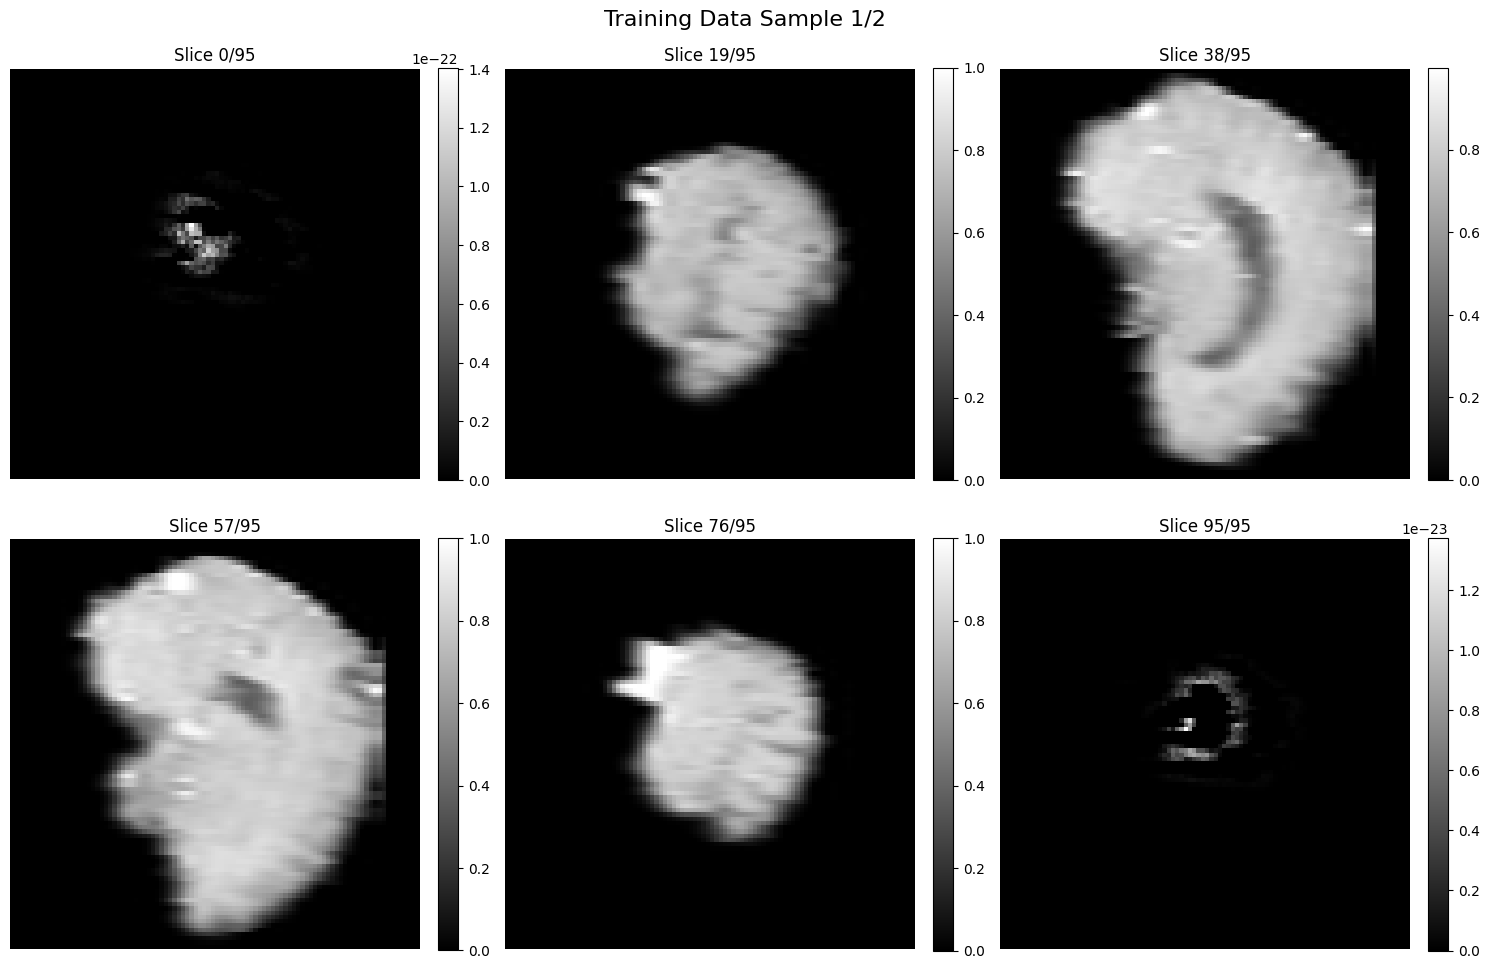

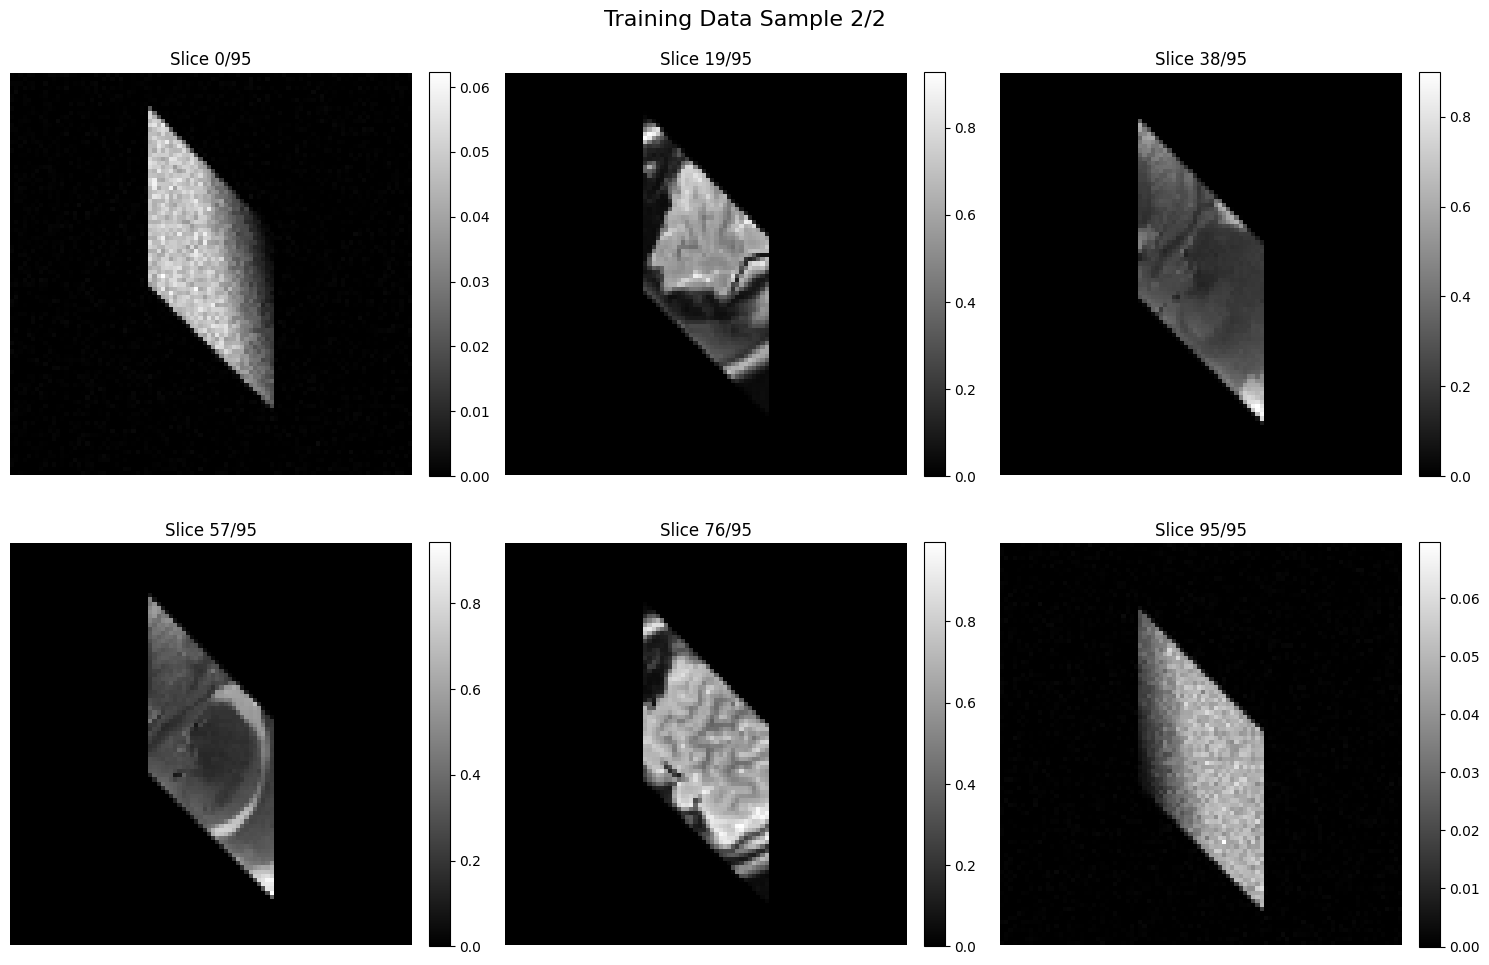

In [35]:
# Plot training data samples
print("=== TRAINING DATA SAMPLES ===")
plot_batch_samples(train_batch, title_prefix="Training Data", num_samples=2)

=== VALIDATION DATA SAMPLES ===


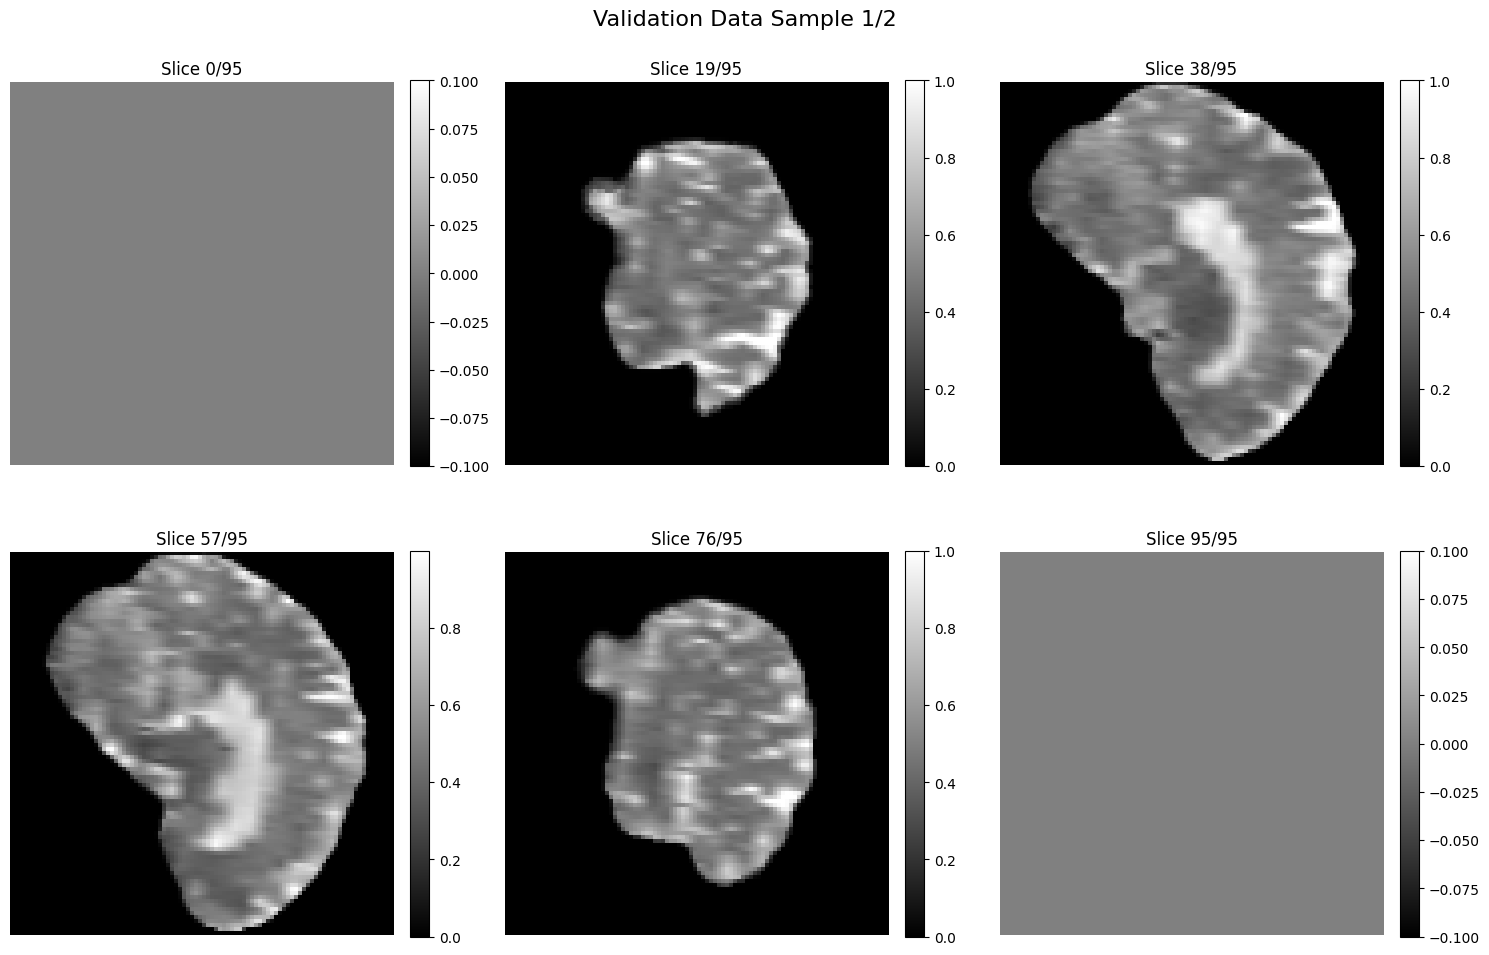

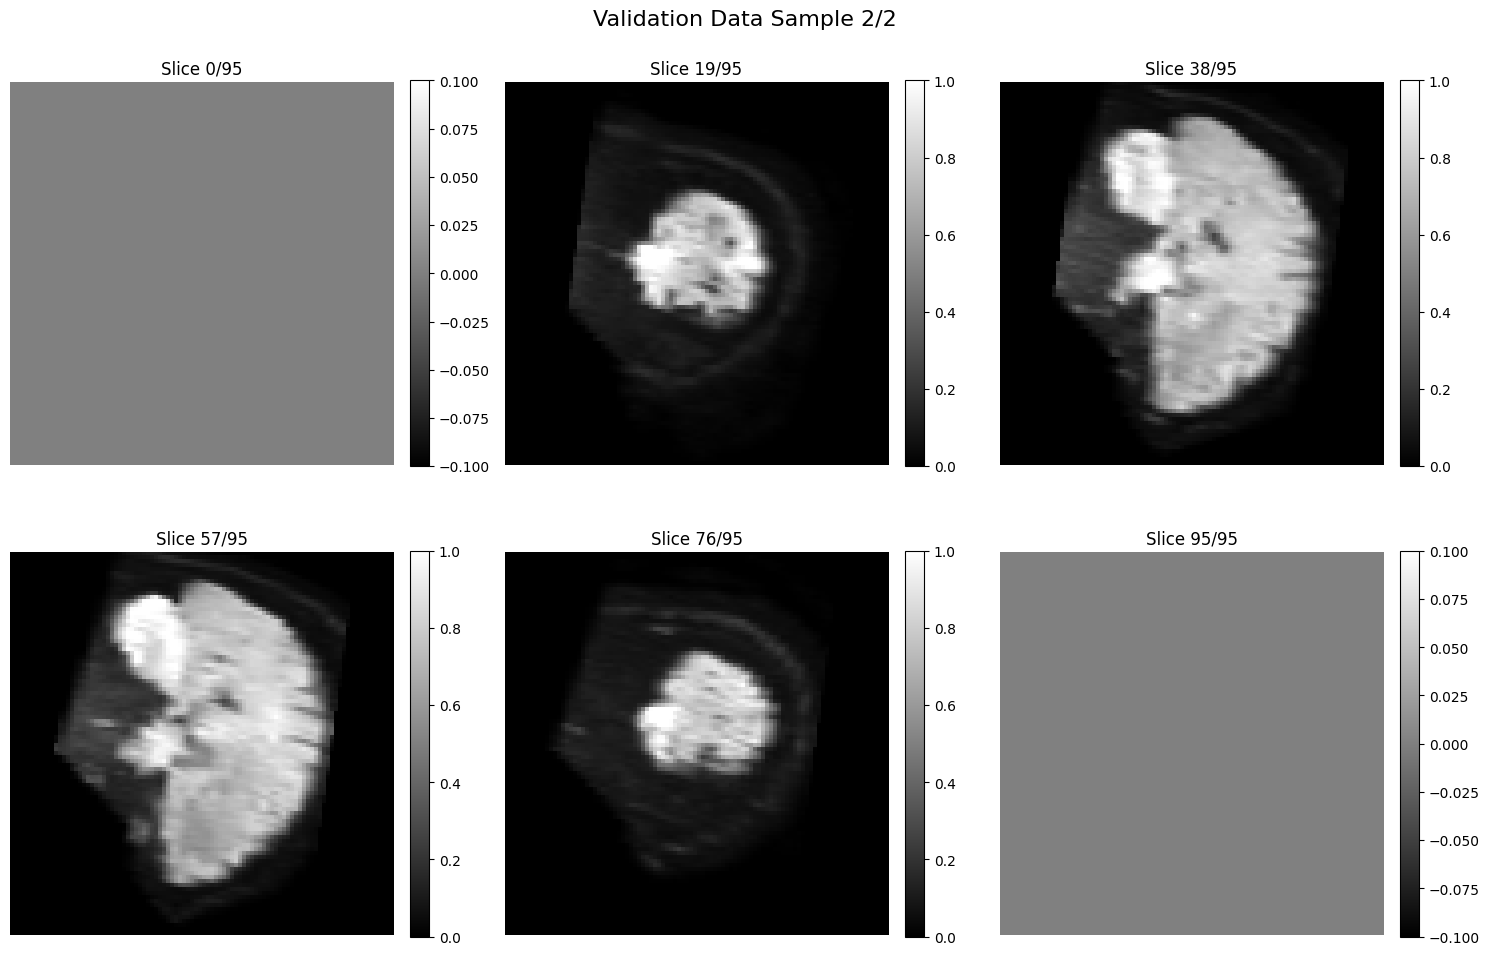

In [36]:
# Plot validation data samples
print("=== VALIDATION DATA SAMPLES ===")
plot_batch_samples(val_batch, title_prefix="Validation Data", num_samples=2)

=== STATISTICAL ANALYSIS ===

Training Batch Statistics:
  Shape: torch.Size([2, 1, 96, 96, 96])
  Data type: torch.float32
  Min value: 0.000000
  Max value: 1.000000
  Mean: 0.116695
  Std: 0.254865
  Memory usage: 6.75 MB
  Sample 1: mean=0.194031, std=0.320158
  Sample 2: mean=0.039358, std=0.124297

Validation Batch Statistics:
  Shape: torch.Size([2, 1, 96, 96, 96])
  Data type: torch.float32
  Min value: 0.000000
  Max value: 1.000000
  Mean: 0.154880
  Std: 0.265262
  Memory usage: 6.75 MB
  Sample 1: mean=0.179035, std=0.269630
  Sample 2: mean=0.130725, std=0.258574


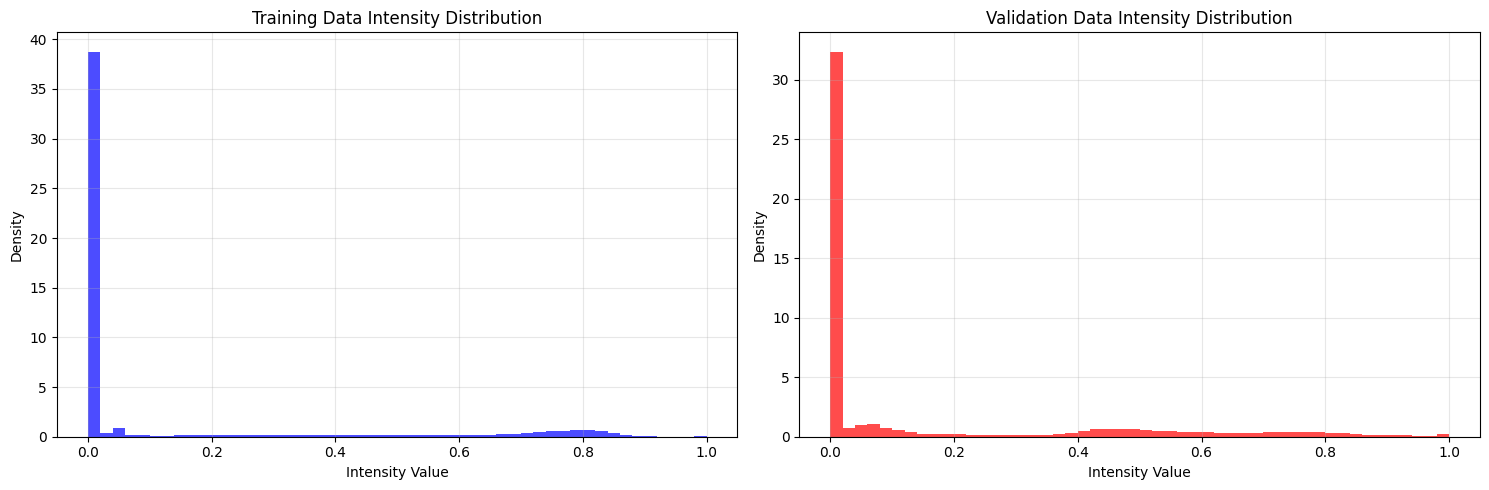


Augmentation Effects:
Training data range: [0.000, 1.000]
Validation data range: [0.000, 1.000]
The difference in ranges suggests augmentations are being applied to training data.


In [37]:
# Statistical analysis and comparison
print("=== STATISTICAL ANALYSIS ===")

def analyze_batch_statistics(batch, batch_name):
    """Analyze and print statistics for a batch of data."""
    data = batch['image']

    print(f"\n{batch_name} Statistics:")
    print(f"  Shape: {data.shape}")
    print(f"  Data type: {data.dtype}")
    print(f"  Min value: {data.min().item():.6f}")
    print(f"  Max value: {data.max().item():.6f}")
    print(f"  Mean: {data.mean().item():.6f}")
    print(f"  Std: {data.std().item():.6f}")
    print(f"  Memory usage: {data.numel() * data.element_size() / 1024**2:.2f} MB")

    # Analyze each sample in the batch
    for i in range(data.shape[0]):
        sample = data[i]
        print(f"  Sample {i+1}: mean={sample.mean().item():.6f}, std={sample.std().item():.6f}")

analyze_batch_statistics(train_batch, "Training Batch")
analyze_batch_statistics(val_batch, "Validation Batch")

# Plot histogram comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

train_data_flat = train_batch['image'].flatten().cpu().numpy()
val_data_flat = val_batch['image'].flatten().cpu().numpy()

ax1.hist(train_data_flat, bins=50, alpha=0.7, color='blue', density=True)
ax1.set_title('Training Data Intensity Distribution')
ax1.set_xlabel('Intensity Value')
ax1.set_ylabel('Density')
ax1.grid(True, alpha=0.3)

ax2.hist(val_data_flat, bins=50, alpha=0.7, color='red', density=True)
ax2.set_title('Validation Data Intensity Distribution')
ax2.set_xlabel('Intensity Value')
ax2.set_ylabel('Density')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAugmentation Effects:")
print(f"Training data range: [{train_data_flat.min():.3f}, {train_data_flat.max():.3f}]")
print(f"Validation data range: [{val_data_flat.min():.3f}, {val_data_flat.max():.3f}]")
print(f"The difference in ranges suggests augmentations are being applied to training data.")

In [38]:
# Data loading performance analysis
import time

print("=== DATA LOADING PERFORMANCE ===")

def measure_loading_time(dataloader, num_batches=5):
    """Measure the time to load a specified number of batches."""
    start_time = time.time()

    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        # Just access the data to ensure it's loaded
        _ = batch['image'].shape

    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_batches

    return total_time, avg_time_per_batch

# Measure training data loading
train_total, train_avg = measure_loading_time(train_loader, num_batches=3)
print(f"Training data loading:")
print(f"  Total time for 3 batches: {train_total:.2f} seconds")
print(f"  Average time per batch: {train_avg:.2f} seconds")

# Measure validation data loading
val_total, val_avg = measure_loading_time(val_loader, num_batches=3)
print(f"Validation data loading:")
print(f"  Total time for 3 batches: {val_total:.2f} seconds")
print(f"  Average time per batch: {val_avg:.2f} seconds")

print(f"\nConfiguration Summary:")
print(f"  Patch size: {(patch_size,) * 3}")
print(f"  Batch size: {batch_size}")
print(f"  Num workers: {num_workers}")
print(f"  Augmentation preset: {augmentation_preset}")
print(f"  Data directory: {pretrain_data_dir}")
print(f"  Train samples: {len(splits_config.train(0))}")
print(f"  Val samples: {len(splits_config.val(0))}")

=== DATA LOADING PERFORMANCE ===


Training data loading:
  Total time for 3 batches: 3.40 seconds
  Average time per batch: 1.13 seconds
Validation data loading:
  Total time for 3 batches: 0.44 seconds
  Average time per batch: 0.15 seconds

Configuration Summary:
  Patch size: (96, 96, 96)
  Batch size: 2
  Num workers: 4
  Augmentation preset: all
  Data directory: /home/mg873uh/Projects_kb/data/pretrain_preproc/FOMO60k
  Train samples: 59922
  Val samples: 606
Validation data loading:
  Total time for 3 batches: 0.44 seconds
  Average time per batch: 0.15 seconds

Configuration Summary:
  Patch size: (96, 96, 96)
  Batch size: 2
  Num workers: 4
  Augmentation preset: all
  Data directory: /home/mg873uh/Projects_kb/data/pretrain_preproc/FOMO60k
  Train samples: 59922
  Val samples: 606


=== RANDOM DATA ITEMS FROM TRAIN_LOADER ===
Random batch shape: torch.Size([2, 1, 96, 96, 96])
Selected random sample index from batch: 1
Random item 'image' shape: torch.Size([1, 96, 96, 96])
Random item 'image' dtype: torch.float32
Random item 'image' range: [0.000, 0.055]
File path: sub_5282_ses_1_t2
Random item 'label' shape: torch.Size([1, 96, 96, 96])
Random item 'label' dtype: torch.float32
Random item 'label' range: [0.000, 1.000]
Random batch shape: torch.Size([2, 1, 96, 96, 96])
Selected random sample index from batch: 1
Random item 'image' shape: torch.Size([1, 96, 96, 96])
Random item 'image' dtype: torch.float32
Random item 'image' range: [0.000, 0.055]
File path: sub_5282_ses_1_t2
Random item 'label' shape: torch.Size([1, 96, 96, 96])
Random item 'label' dtype: torch.float32
Random item 'label' range: [0.000, 1.000]


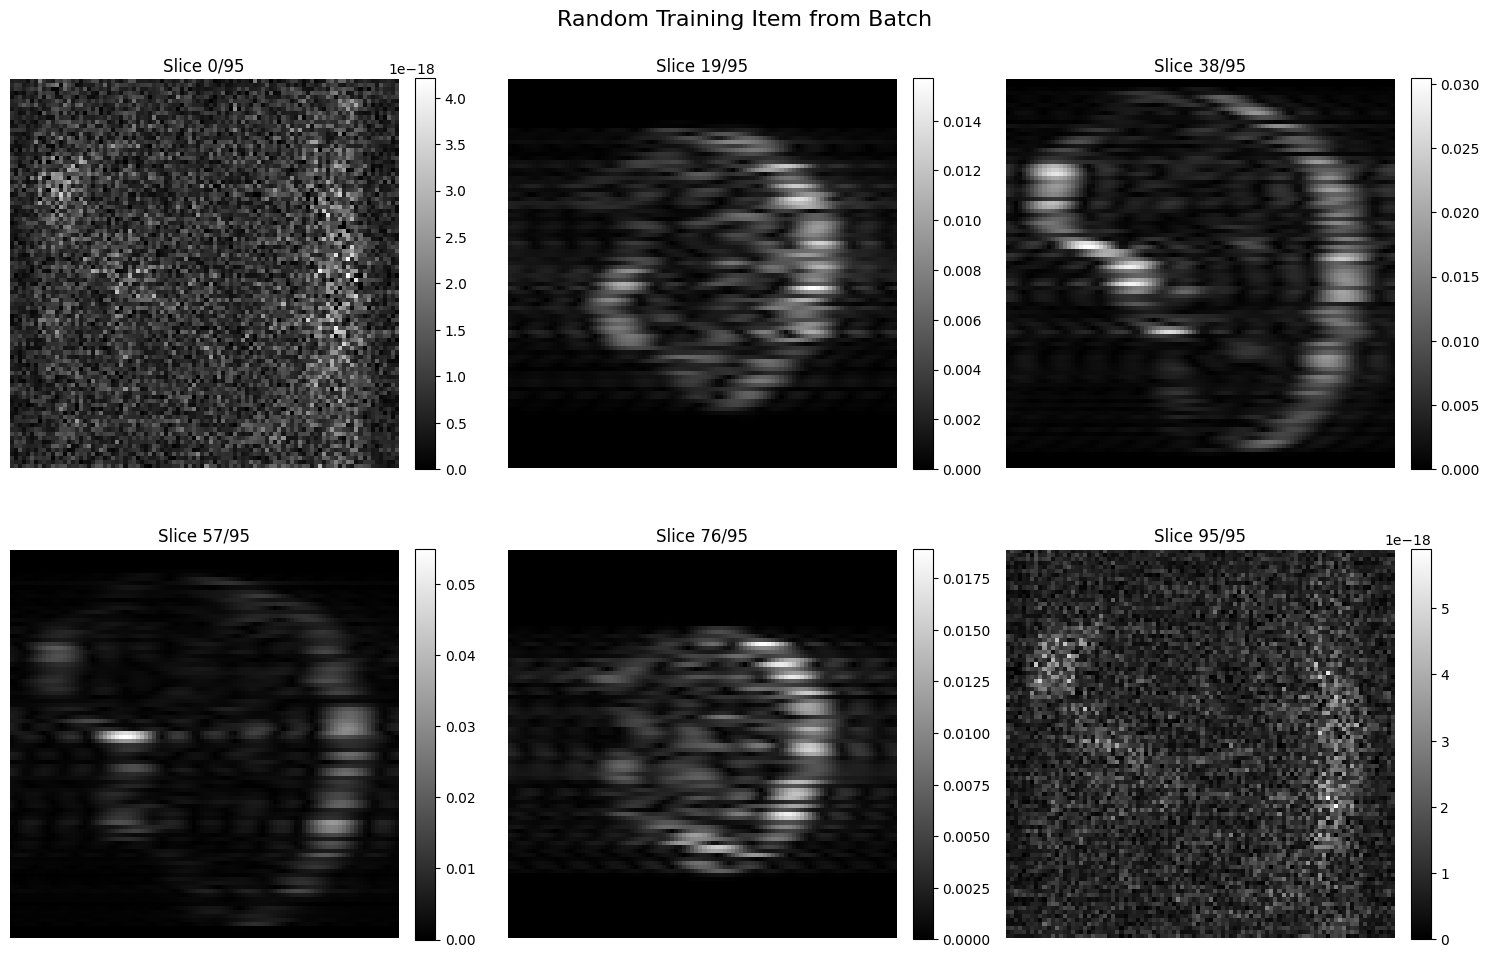


Alternative: You can also iterate through train_loader to get different batches:
for i, batch in enumerate(train_loader):
    if i == desired_batch_index:
        # Process this batch
        break


In [39]:
# Get random data items using train_loader
import random

print("=== RANDOM DATA ITEMS FROM TRAIN_LOADER ===")

# Method 1: Get a random batch and pick a random sample from it
random_batch = next(iter(train_loader))
batch_size = random_batch['image'].shape[0]
random_sample_idx = random.randint(0, batch_size - 1)

print(f"Random batch shape: {random_batch['image'].shape}")
print(f"Selected random sample index from batch: {random_sample_idx}")

# Extract the random sample
random_item = {
    'image': random_batch['image'][random_sample_idx],
    'file_path': random_batch['file_path'][random_sample_idx]
}

print(f"Random item 'image' shape: {random_item['image'].shape}")
print(f"Random item 'image' dtype: {random_item['image'].dtype}")
print(f"Random item 'image' range: [{random_item['image'].min():.3f}, {random_item['image'].max():.3f}]")
print(f"File path: {random_item['file_path']}")

# If there's a label, show its info too
if 'label' in random_batch and random_batch['label'] is not None:
    random_item['label'] = random_batch['label'][random_sample_idx]
    print(f"Random item 'label' shape: {random_item['label'].shape}")
    print(f"Random item 'label' dtype: {random_item['label'].dtype}")
    print(f"Random item 'label' range: [{random_item['label'].min():.3f}, {random_item['label'].max():.3f}]")

# Plot the random item
def plot_single_item(item, title="Random Data Item"):
    """Plot a single data item."""
    image = item['image']
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    plot_3d_volume_slices(image, title=title, num_slices=6)

plot_single_item(random_item, title=f"Random Training Item from Batch")

print("\n" + "="*50)
print("Alternative: You can also iterate through train_loader to get different batches:")
print("for i, batch in enumerate(train_loader):")
print("    if i == desired_batch_index:")
print("        # Process this batch")
print("        break")